# Brain Tumor Classification Using CNN

A brain tumor is a mass or collection of abnormal cells within the brain. Due to the rigidity of the skull, any abnormal growth inside this restricted space can lead to increased intracranial pressure, causing severe complications such as brain damage and, in some cases, can be life-threatening. Brain tumors can be either:

Benign (non-cancerous): Less aggressive and slow-growing.
Malignant (cancerous): Fast-growing and invasive, posing significant health risks.

### Importance of Early Detection
Early detection and accurate classification of brain tumors are crucial for providing effective treatment and improving patient outcomes. This is an important research domain in medical imaging and significantly aids healthcare professionals in determining the most appropriate treatment strategies.

According to the World Health Organization (WHO), a proper diagnosis involves:

Detecting the presence of a brain tumor.
Identifying its location.
Classifying the tumor based on its type, grade, and malignancy.

#### Objective 

In this notebook, I aim to leverage the power of Deep Learning, specifically Convolutional Neural Networks (CNNs), to tackle the challenge of brain tumor detection and classification using MRI images. This project is my attempt to explore how modern AI techniques can make an impact in healthcare by providing fast, accurate, and scalable solutions for complex diagnostic tasks.

By focusing on brain tumor classification, I hope to demonstrate how CNNs can help automate critical aspects of medical diagnosis, potentially aiding early detection and improving treatment decisions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


#### Visualizing a Batch of Training Images with Their Corresponding Labels

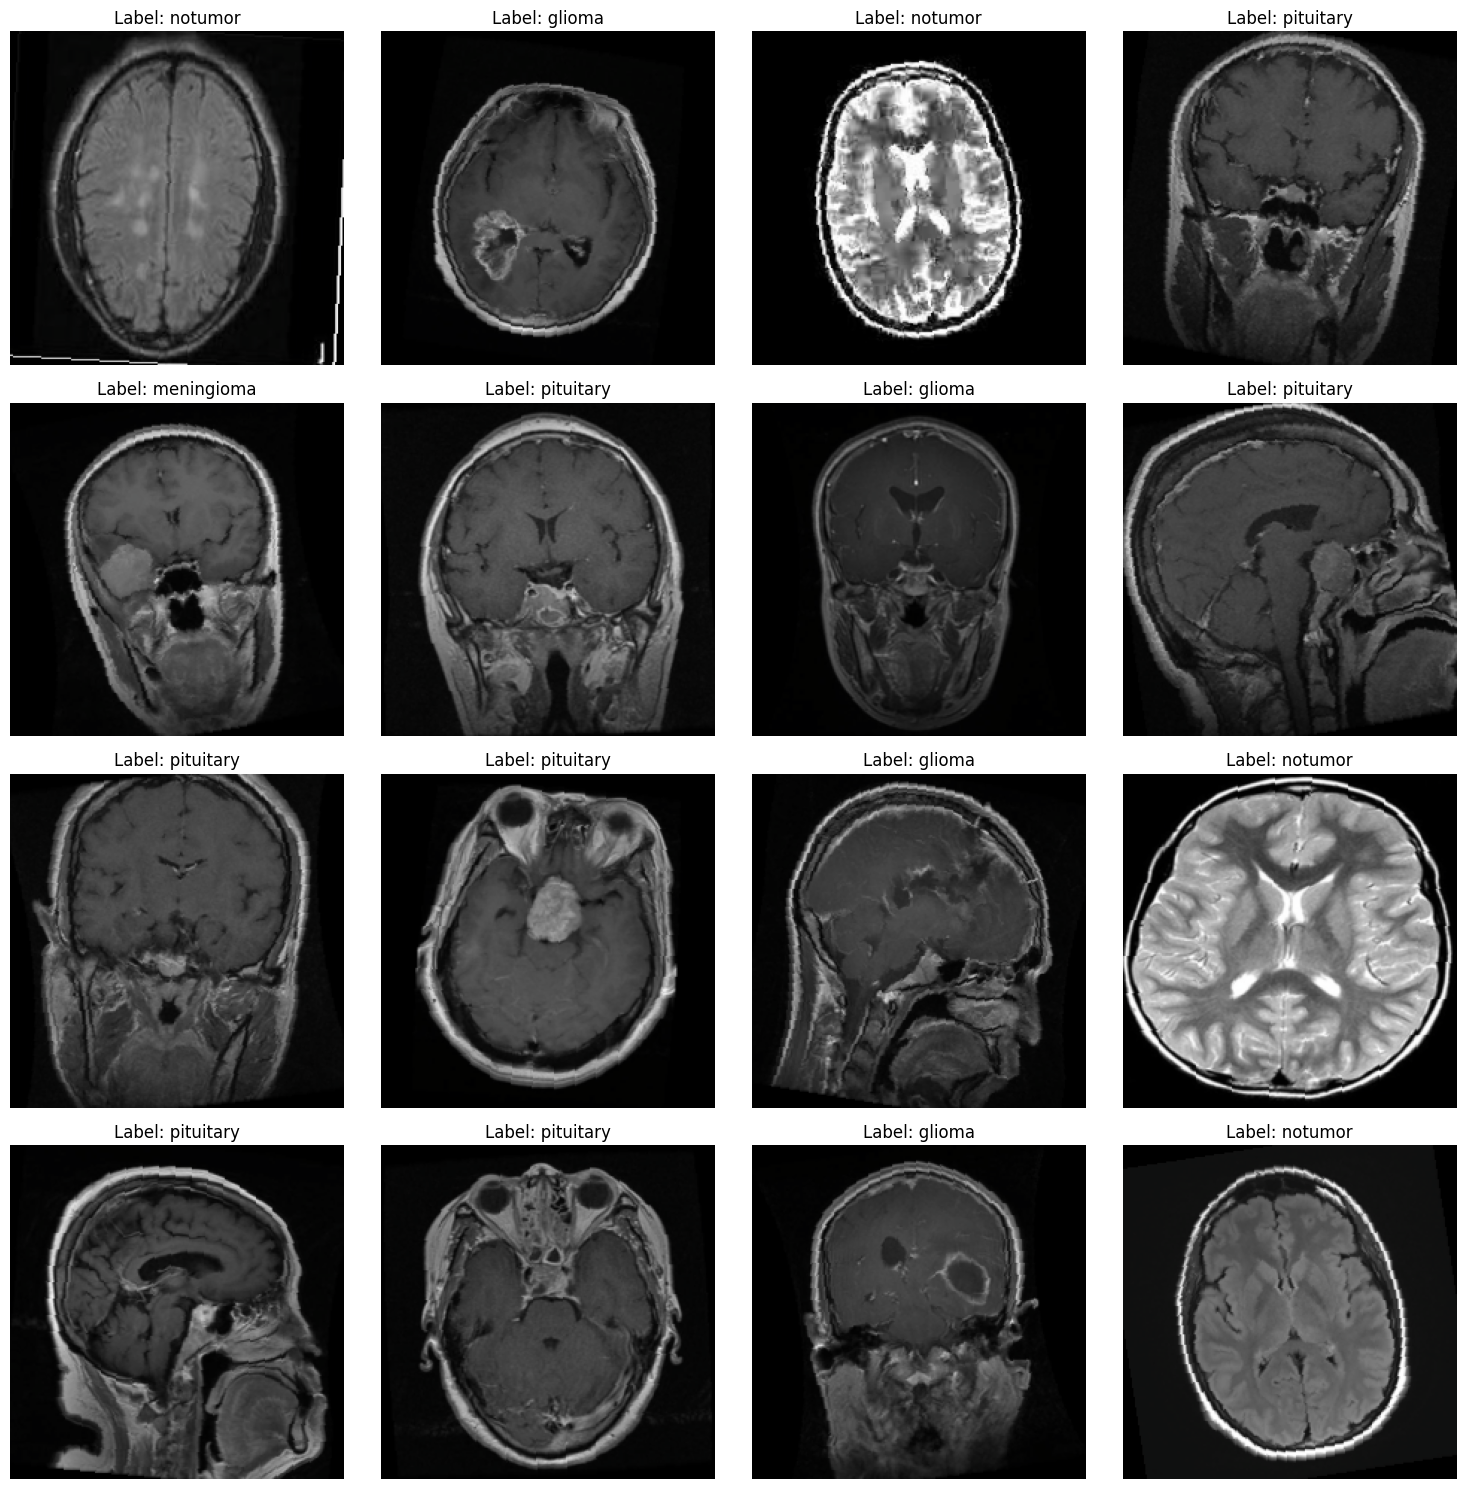

In [4]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### IMPLEMENTATION OF MODEL 

In this project, I implemented a custom Convolutional Neural Network (CNN) architecture, specifically designed for brain tumor classification. The model consists of two main components:

1. Feature Extractor:

Sequential convolutional layers to extract spatial features from input MRI images.
Two convolutional layers with ReLU activations and max-pooling operations to progressively reduce the spatial dimensions and capture essential patterns.
Classifier:

2. Fully connected (dense) layers to map the extracted features to the output classes.
Two linear layers with ReLU activations that reduce the feature space and classify the image into one of 4 categories (glioma, meningioma, no tumor, pituitary).


In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Feature extraction layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected classification layers
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the features
        x = x.view(x.size(0), -1)
        
        # Classification layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

# Create model and move to device
model = TumorClassifier(num_classes=4)
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

The loss function used is CrossEntropyLoss. The optimizer chosen is Adam with a learning rate of 0.001.

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [8]:
# Training loop
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/20], Training Loss: 238.7747, Training Accuracy: 77.26%, Validation Loss: 0.4632, Validation Accuracy: 82.99%
Epoch [2/20], Training Loss: 117.4645, Training Accuracy: 87.32%, Validation Loss: 0.2583, Validation Accuracy: 90.16%
Epoch [3/20], Training Loss: 81.2155, Training Accuracy: 91.28%, Validation Loss: 0.2952, Validation Accuracy: 90.31%
Epoch [4/20], Training Loss: 59.8604, Training Accuracy: 94.38%, Validation Loss: 0.2405, Validation Accuracy: 91.08%
Epoch [5/20], Training Loss: 49.3930, Training Accuracy: 94.99%, Validation Loss: 0.1705, Validation Accuracy: 94.05%
Epoch [6/20], Training Loss: 34.6401, Training Accuracy: 96.67%, Validation Loss: 0.2779, Validation Accuracy: 92.37%
Epoch [7/20], Training Loss: 28.9799, Training Accuracy: 97.27%, Validation Loss: 0.1466, Validation Accuracy: 95.50%
Epoch [8/20], Training Loss: 19.8998, Training Accuracy: 97.97%, Validation Loss: 0.1782, Validation Accuracy: 94.74%
Epoch [9/20], Training Loss: 22.9324, Training Accurac

In [10]:
accuracy = correct / total
print(f'Test Accuracy: {accuracy:.2%}')

Test Accuracy: 97.10%


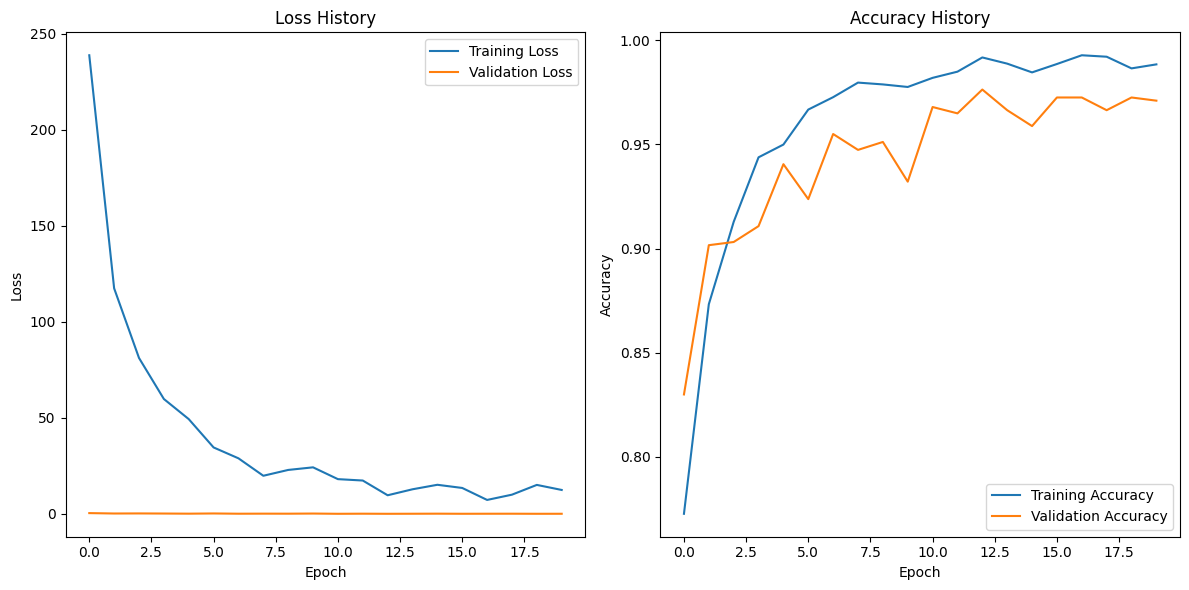

In [11]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

#### RESULTS 

The model achieved a training accuracy of 98.65% and a validation accuracy of 97.10% by the final epoch, indicating its ability to generalize well to unseen data.